# Predicting Bike Sharing patterns

In this project, a simple neural network is implemented from scratch and is used to predict daily bike rental ridership.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and prepare the data

Loading the data and normalizing it. Variables on different scales make it difficult for the network to efficiently learn the correct weights. 


In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

### Checking the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. 

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

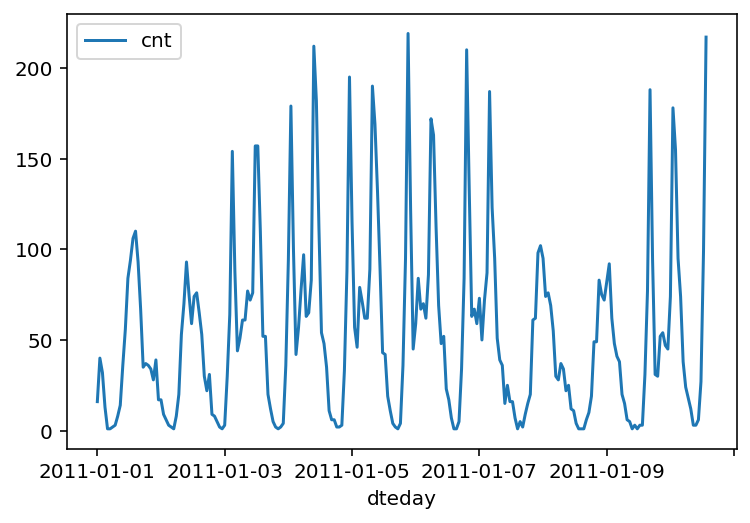

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### Building the network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. All of the outputs from one layer become inputs to the neurons on the next layer. 

<img src="assets/neural_network.png" width=300px>

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. 

In [9]:
import numpy as np


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(
            0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(
            0.0, self.hidden_nodes**-0.5,
            (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        self.activation_function = lambda x: 1 / (1 + np.exp(-x))

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 

            Arguments
            ---------

            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values

        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # forward pass function
            # the backproagation function
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(
                final_outputs, hidden_outputs, X, y, delta_weights_i_h,
                delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

    def forward_pass_train(self, X):
        ''' Implement forward pass here 

            Arguments
            ---------
            X: features batch

        '''
        ### Forward pass ###
        hidden_inputs = np.matmul(X, self.weights_input_to_hidden)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

        final_inputs = np.matmul(
            hidden_outputs,
            self.weights_hidden_to_output)  # signals into final output layer
        final_outputs = final_inputs  # signals from final output layer

        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y,
                        delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation

            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        # Output layer error is the difference between desired target and actual output.
        error = y - final_outputs

        # Backpropagated error terms
        output_error_term = error

        hidden_error = np.matmul(error, self.weights_hidden_to_output.T)

        hidden_error_term = hidden_error * hidden_outputs * (1 -
                                                             hidden_outputs)

        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step

            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records  # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 

            Arguments
            ---------
            features: 1D array of feature values
        '''

        # Hidden layer
        hidden_inputs = np.matmul(
            np.array(features),  # added this numpy wrapping due to the internal bug/error of pandas lib with implied shape vs actual shape after numpy tries to use the dataframe directly in matmul.
            self.weights_input_to_hidden)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

        final_inputs = np.matmul(
            hidden_outputs,
            self.weights_hidden_to_output)  # signals into final output layer
        final_outputs = final_inputs  # signals from final output layer

        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here we'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but not to overfit to the data. If the network is trained too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

We'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, a random sample of the data is grabbed instead of using the whole data set. We use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

#### the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations the better the model will fit the data. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

#### the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. The lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

#### the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

In [32]:
import sys

####################
### hyperparameters
####################

iterations = 2000
learning_rate = 1.6
hidden_nodes = 7
output_nodes = 1

N_i = train_features.shape[1]

# lets define some Neural Networks with different hidden nodes and different learning rates
# we will chart the loss of these networks to compare them
hidden_nodes =  [7,   8,   9,   10  ]
learning_rate = [1.5, 1.6, 1.8, 1.9]

# lets define our list of Neural Networks
networks = []
for i in range(4):
    networks.append(NeuralNetwork(N_i, hidden_nodes[i], output_nodes, learning_rate[i])) 

losses = {
    'train_0':[], 'validation_0':[],
    'train_1':[], 'validation_1':[],
    'train_2':[], 'validation_2':[],
    'train_3':[], 'validation_3':[]
}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    sstr = "\rProgress: {:2.1f}%".format(100 * ii/float(iterations)) 
    # Printing out the training progress
    for i, network in enumerate(networks):
        network.train(X, y)    
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sstr = sstr + " | loss_t "+str(i)+": " + str(train_loss)[:5] \
                         + " | loss_v "+str(i)+": " + str(val_loss)[:5]
        losses['train_'+str(i)].append(train_loss)
        losses['validation_'+str(i)].append(val_loss)

    sys.stdout.write(sstr)
    sys.stdout.flush()

Progress: 100.0% | loss_t 0: 0.071 | loss_v 0: 0.180 | loss_t 1: 0.071 | loss_v 1: 0.173 | loss_t 2: 0.066 | loss_v 2: 0.163 | loss_t 3: 0.515 | loss_v 3: 0.626

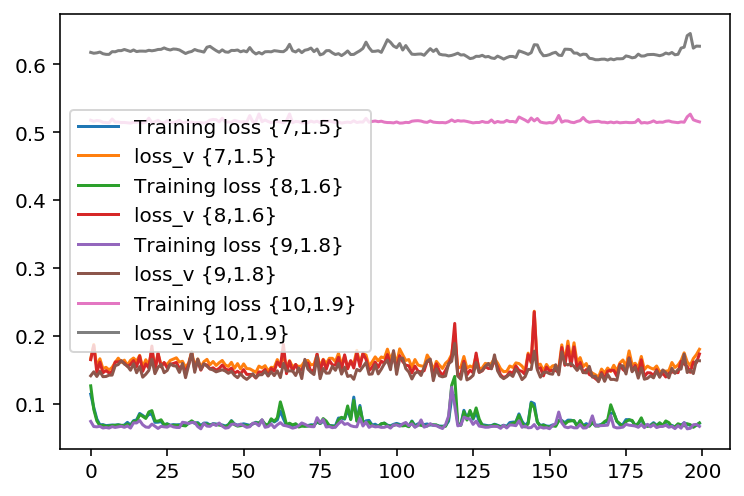

In [33]:
for i in range(4):
    plt.plot(losses['train_'+str(i)][1800:], label='Training loss {'+str(hidden_nodes[i])[:2]+','+str(learning_rate[i])[:3]+'} ')
    plt.plot(losses['validation_'+str(i)][1800:], label='loss_v {'+str(hidden_nodes[i])[:2]+','+str(learning_rate[i])[:3]+'} ')
plt.legend()
#_ = plt.ylim()

As we see above, tuning parameters can be ticky. Just a small diversion from your fine-tuned ultimate value would result in diverged results. So in practice it is always advised to try out as many parameter values as possile and tune your parameters constantly.


### Check out predictions


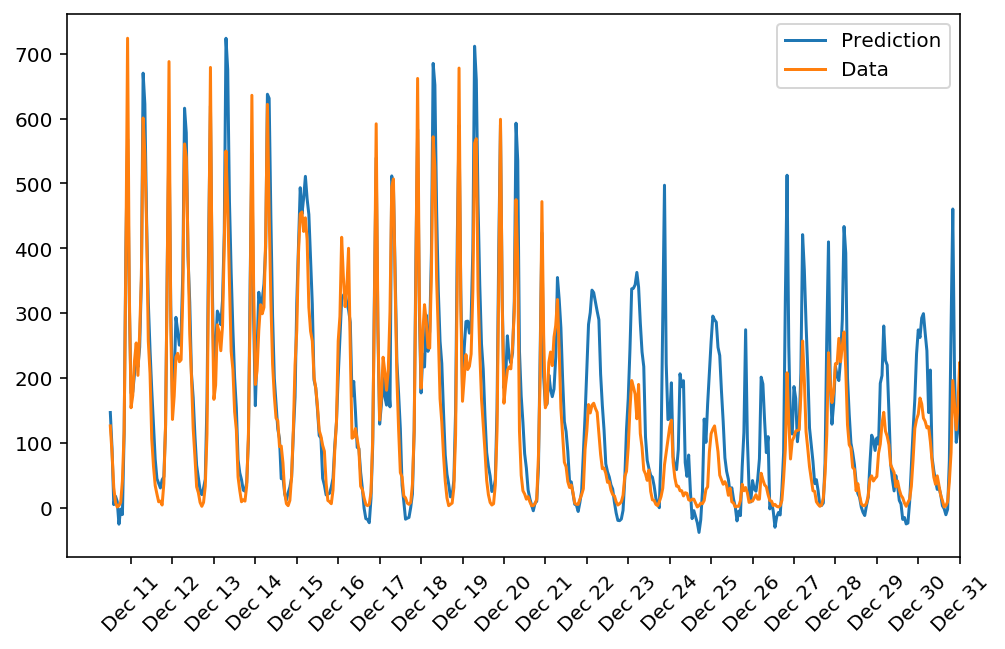

In [43]:
fig, ax = plt.subplots(figsize=(8,5))

mean, std = scaled_features['cnt']
predictions = networks[0].run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

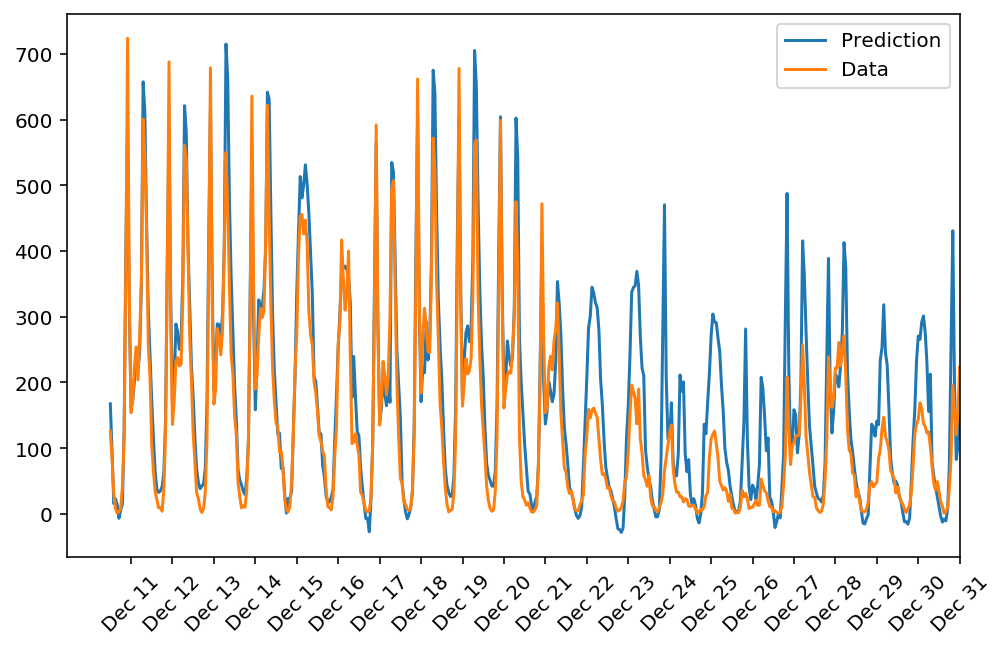

In [44]:
fig, ax = plt.subplots(figsize=(8,5))

mean, std = scaled_features['cnt']
predictions = networks[1].run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

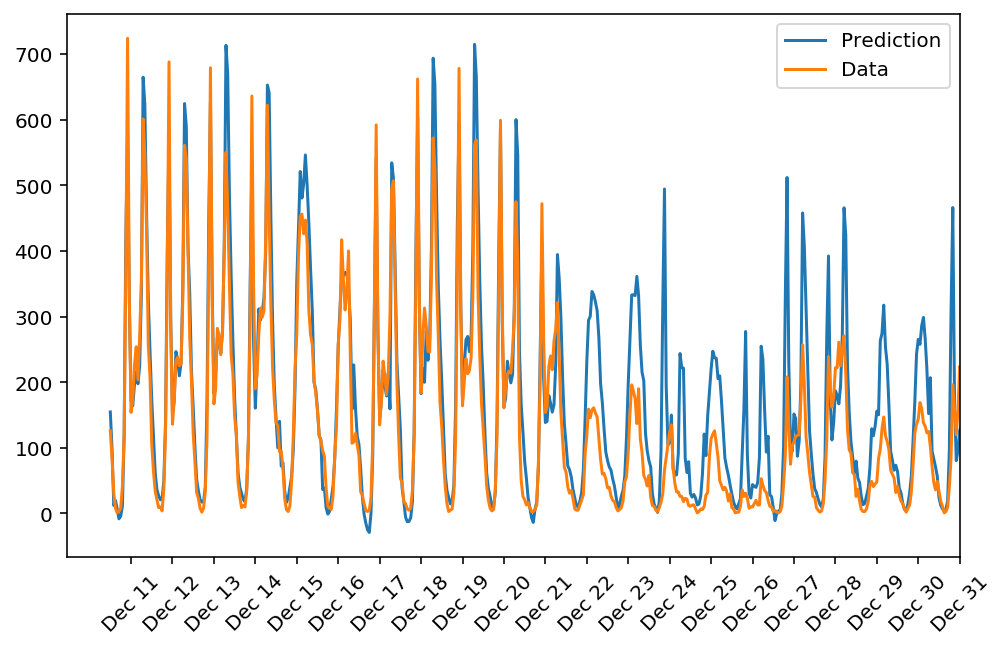

In [45]:
fig, ax = plt.subplots(figsize=(8,5))

mean, std = scaled_features['cnt']
predictions = networks[2].run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

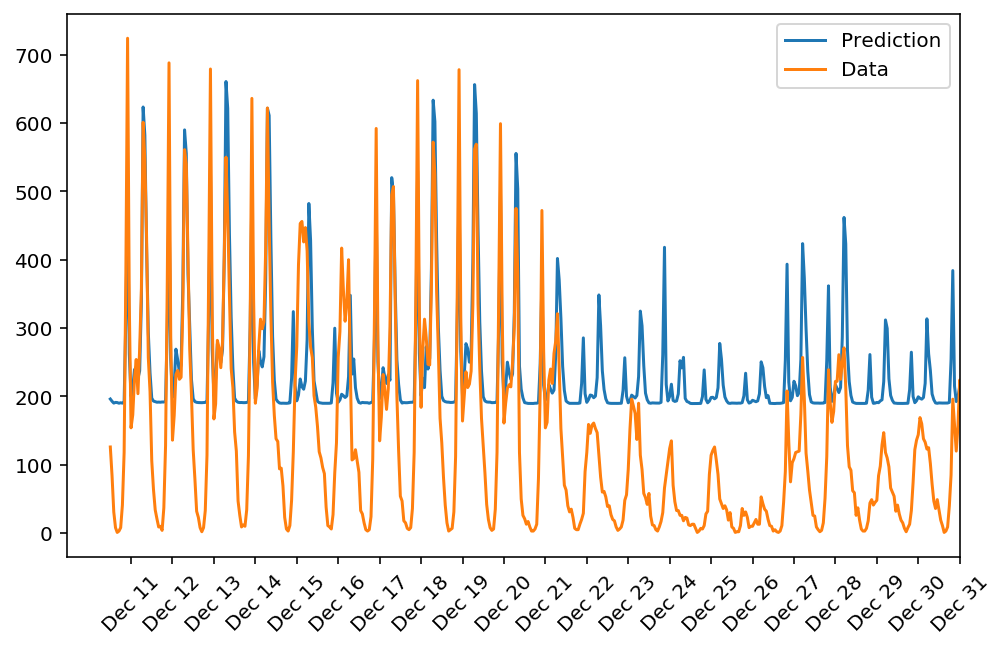

In [48]:
fig, ax = plt.subplots(figsize=(8,5))

mean, std = scaled_features['cnt']
predictions = networks[3].run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

As we see in the above figures, our models can predict the bike-sharing pattern quite nicely (except the last one).
However, our predictions lack accuracy in the later data, generally breaking up from real data around December 22. This means that our network is not able to fully realize the bigger picture and cope with the pattern of changes in input data.

#### Conclusion

Here a simple implementation of neural network in python was presented with no additional libraries. In real world using libraries like pytorch, tensorflow and keras is recommended to prevent any implementation mishaps and also reduce the amount of code. These libraries help us avoid rewriting repeative forward propagation and backward propagation in and also between layers, not to mention providing basic ML functions like sigmoid activation function that we defined ourselves above. 

In this notebook, a feedforward neural network was presented with a hidden layer and a conservative training. To counter the overfitting of data, we had to restrict our network to have only one hidden layer. Since this neural network is only two layers deep, we cannot expect it to find sophisticated patterns in our input dataset. 

Nowadays, to predict a time-series data or any other data sequences, a more progressive network (e.g. Recurrent Neural Network) and a more progressive training algorithm (e.g. Adam) is utilized. In fact, a combination of differnt networks (e.g. CNNs, RNNs, FFs) and different overfitting avoidance methods (e.g. Dropout, regularization) are used to battle the complexity of input data and mimick the hidden pattern in data.